In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import v2

In [2]:
dataset_path = '/Users/Xcalibur/Documents/Datasets/household_waste_dataset/images/images'

full_dataset = ImageFolder(dataset_path)

In [3]:
class_map_dict = full_dataset.class_to_idx

def get_class(num_label):
    for class_name, class_index in class_map_dict.items():
        if class_index == num_label:
            return class_name
    return None

class_names = list(class_map_dict.keys())
print(f'number of classes: {len(class_names)}')

number of classes: 30


In [4]:
# Data Splitting
batch_size = 16
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_transform = v2.Compose([
    v2.RandomHorizontalFlip(0.3),
    v2.RandomVerticalFlip(0.3),
    v2.RandomRotation(degrees=[10,20]),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomTransform(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, target = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.dataset)

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_dataset = CustomTransform(train_dataset, transform=train_transform)
test_dataset = CustomTransform(test_dataset, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

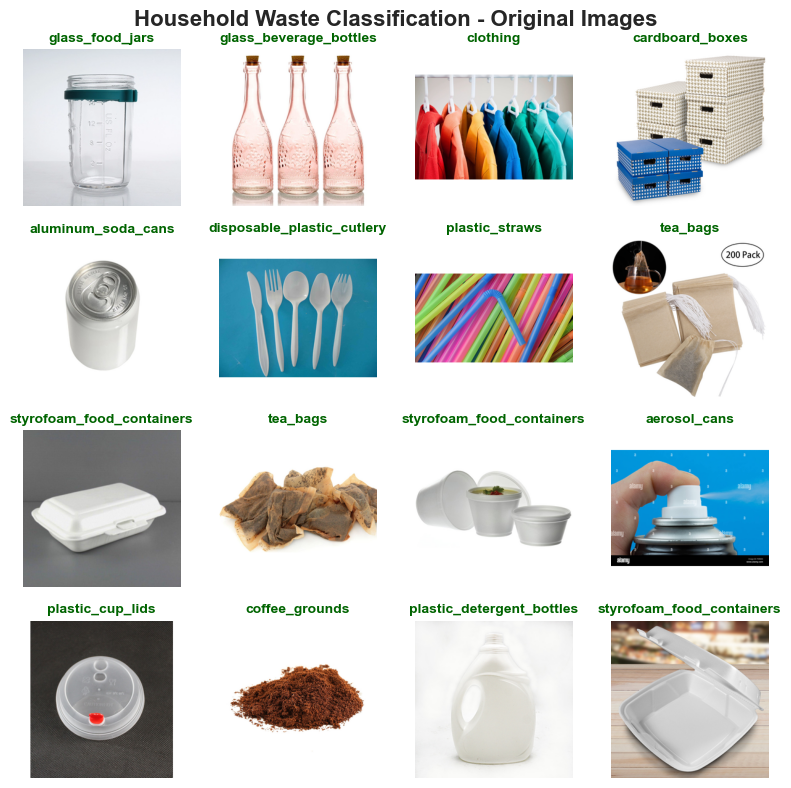

In [6]:
# Display original images from the full dataset (no transformations)
import random

sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Original Images', fontsize=16, fontweight='bold')

# Get 16 random samples 
sample_indices = random.sample(range(len(full_dataset)), 16)

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4
    
    original_img, label = full_dataset[idx]
    img_array = np.array(original_img)

    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"{get_class(label)}", 
                            fontsize=10, fontweight='semibold', 
                            color='darkgreen')
    axes[row, col].axis("off")
    
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("Set2", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()

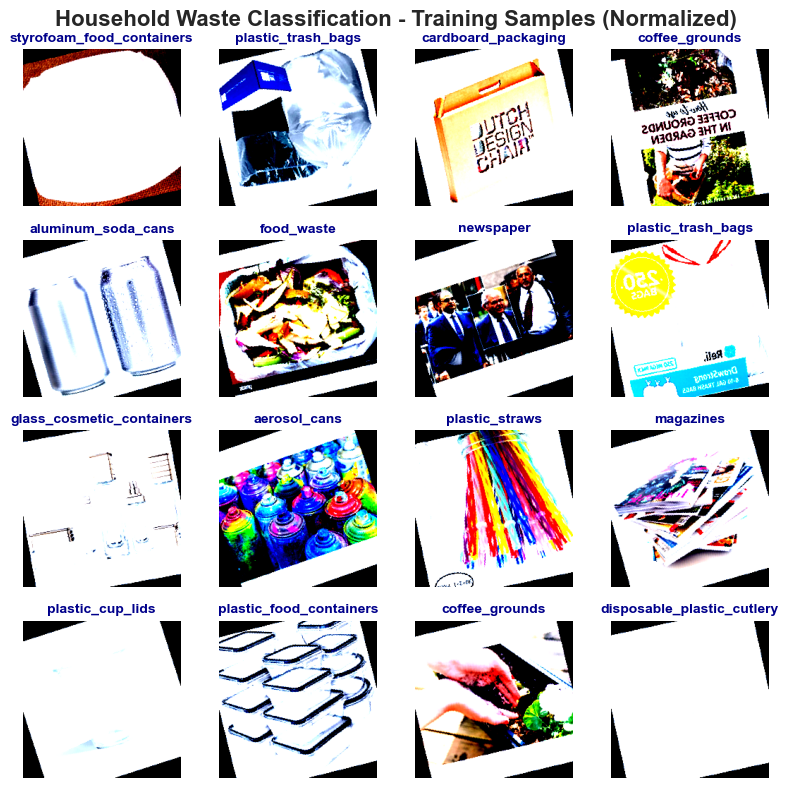

In [7]:
import logging
# Suppress matplotlib's "Clipping input data..." messages
logging.getLogger("matplotlib").setLevel(logging.ERROR)

train_sample_batch, train_labels = next(iter(train_loader))

sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Training Samples (Normalized)', fontsize=16, fontweight='bold')

for i in range(min(16, len(train_sample_batch))):
    row = i // 4
    col = i % 4
    
    img, label = train_sample_batch[i], train_labels[i]
    img_display = img.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img_display, vmin=img_display.min(), vmax=img_display.max())
    axes[row, col].set_title(f"{get_class(label.item())}", 
                            fontsize=10, fontweight='semibold', 
                            color='darkblue')
    axes[row, col].axis("off")
    
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("husl", 8)[label % 8])
        spine.set_linewidth(2)
    
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()


In [8]:
import torch.optim as optim
from tqdm import tqdm

In [13]:
waste_classifier = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 224, 224]
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),                                   # [B, 32, 112, 112]

    nn.Conv2d(32, 64, kernel_size=3, padding=1),          # [B, 64, 112, 112]
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),                                   # [B, 64, 56, 56]

    nn.Conv2d(64, 128, kernel_size=3, padding=1),         # [B, 128, 56, 56]
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),                                   # [B, 128, 28, 28]

    nn.Flatten(),                                         # [B, 100,352]
    nn.Linear(128 * 28 * 28, 512),                        # [B, 512]
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),                                  # [B, 256]
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(256, 30)                                    # [B, 30]
)


dummy_input = torch.randn(1, 3, 224, 224)
waste_classifier.eval()  # Set the model to evaluation mode
output = waste_classifier(dummy_input)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 30])


In [15]:
import torchsummary

torchsummary.summary(waste_classifier, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 512]      51,380,736
             ReLU-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
      BatchNorm1d-14                  [

In [17]:
epochs = 20
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(waste_classifier.parameters(), lr=lr)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

#putting model and optimizer states to gpu
waste_classifier.to(device)

for k, v in optimizer.state_dict().items():
    if isinstance(v, torch.Tensor):
        optimizer.state_dict()[k] = v.to(device)

train_loss, train_correct, train_total = 0.0, 0, 0
test_loss, test_correct, test_total = 0.0, 0, 0
for epoch in range(epochs):
    waste_classifier.train()
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs} : ", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = waste_classifier(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())
        
        train_loss += loss.item() * images.size(0) # [batch_size = 16, 3, 244, 244]
        train_correct += (outputs.argmax(dim=1) == labels).sum().item() # extract python int from tensor
        train_total += labels.size(0)
        
    waste_classifier.eval()
    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Testing Epoch {epoch+1}/{epochs} : ", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = waste_classifier(images)
            loss = loss_fn(outputs, labels)
            pbar.set_postfix(loss=loss.item())

            test_loss += loss.item() * images.size(0)
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            test_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    test_loss /= test_total
    test_acc = test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")